In [8]:
import logging

logging.basicConfig(level=logging.INFO)

In [9]:
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss, MSELoss

# from pennylane import NesterovMomentumOptimizer
from qcc.qcnn import QCNN

from qcc.ml.data import Data, BinaryData
from qcc.ml.optimize import Optimizer
from qcc.ml.data import ImageTransform, ImageTransform1D
from qcc.experiment import Experiment
from qcc.cnn import CNN

from pathlib import Path
from qcc.file import save_dataframe_as_csv

# from qcc.quantum.operation.ansatz import ConvolutionPoolingAnsatz as Ansatz
from qcc.quantum.operation.ansatz import BaselineAnsatz as Ansatz

# from qcc.quantum.operation.ansatz.basic import BasicFiltering6
from qcc.quantum.operation.fully_connected import FullyConnected

In [10]:
# Meta parameters
name = "test"
path = Path(f"results/{name}")
num_trials = 1
silent = False
is_quantum = True

# Ansatz parameters
dims = (32, 32, 3)
num_layers = 4
options = {
    # "U_filter": BasicFiltering6,
    # "U_fully_connected": None,
    # "pooling": True
    # "filter_shape": (2, 2, 2)
}

2023-07-25 03:24:23,986: (qcnn) Circuit ID: test
INFO:qcc.quantum.operation.ansatz.ansatz:Depth: 14
INFO:qcc.quantum.operation.ansatz.ansatz:Gate Count: 66


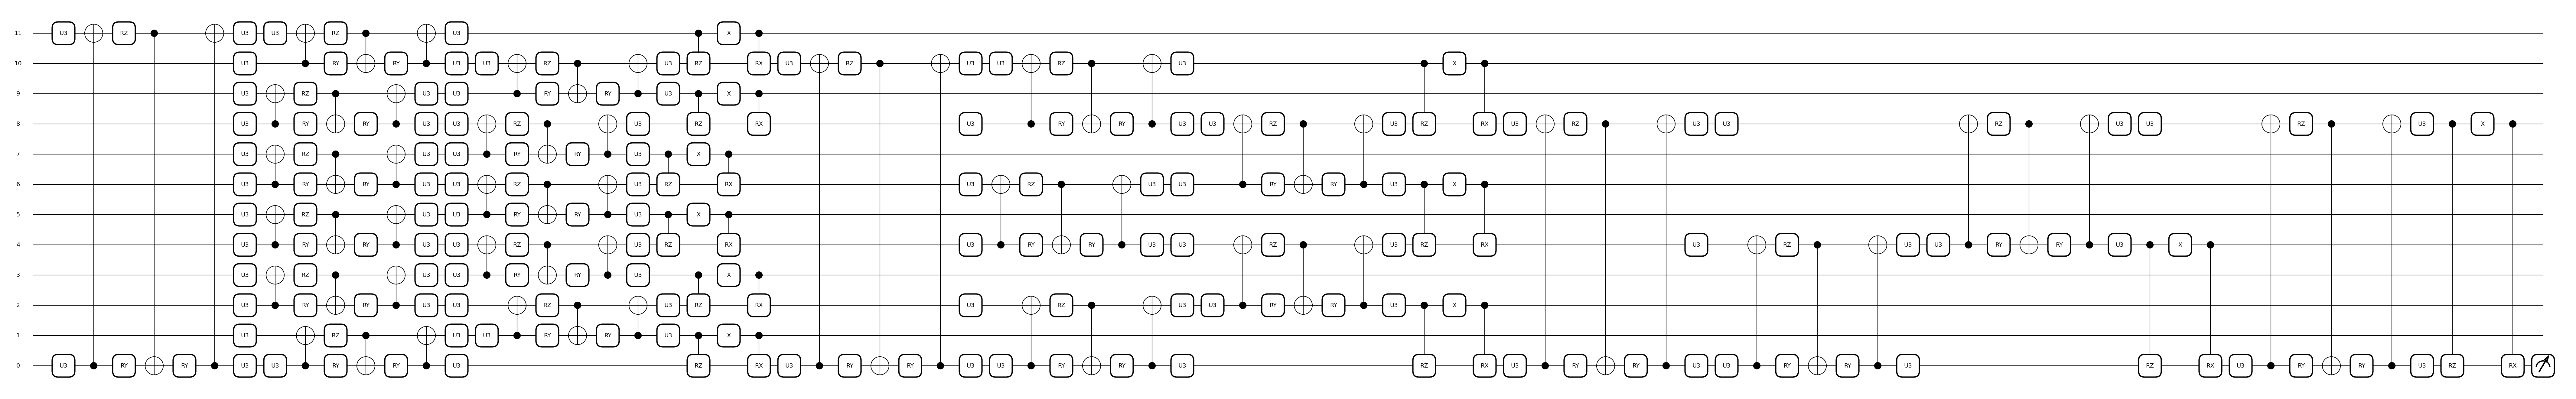

In [11]:
# Create model
cls = QCNN if is_quantum else CNN
data = BinaryData(CIFAR10, ImageTransform(dims, flatten=is_quantum), batch_size=(40, 1000))
# optimizer = Optimizer(SGD, lr=0.01, momentum=0.9, nesterov=True)
optimizer = Optimizer(Adam)
loss = CrossEntropyLoss()
epoch = 20
model = cls.with_logging(data, optimizer, loss, epoch=epoch)

# Log circuit ID
model.logger.info(f"Circuit ID: {name}")

# Save circuit drawing
if is_quantum:
    model.ansatz = Ansatz.from_dims(dims, num_layers=num_layers, **options)
    filename = path.with_stem(f"{name}_circuit").with_suffix(".png")
    model.ansatz.draw(filename=filename, decompose=True)

In [12]:
# Run experiment
results_schema=["accuracy", "training_time", "testing_time"]
experiment = Experiment(model, num_trials, results_schema=results_schema)

args = (Ansatz,) if is_quantum else ()
results = experiment(*args, dims, num_layers=num_layers, silent=silent, **options)

INFO:qcc.quantum.operation.ansatz.ansatz:Depth: 14
INFO:qcc.quantum.operation.ansatz.ansatz:Gate Count: 66


Files already downloaded and verified
Files already downloaded and verified


2023-07-25 03:24:27,144: (qcnn_trial_0) Number of Parameters: 68


In [ ]:
# Save and print accuracy results
save_dataframe_as_csv(path.with_suffix(".csv"), results)
acc = results["accuracy"]
print(acc.median(), acc.mean(), acc.std())

0.6930000185966492 0.6930000185966492 0.0


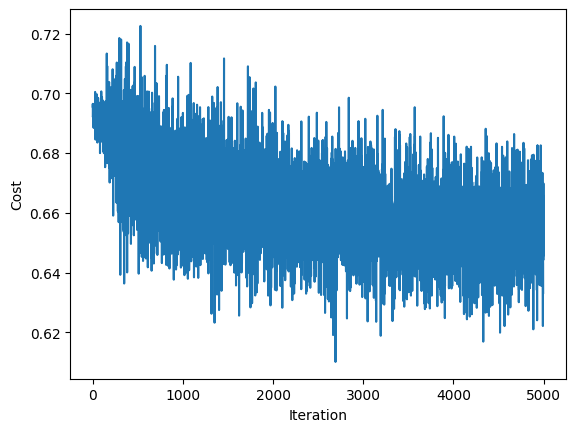

In [ ]:
# Save aggregated loss history figure
(fig,) = experiment.draw(path.with_suffix(".png"))